In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [2]:
data = pd.read_csv('./Admission_Predict.csv', sep=",")

Изучим наш датасет на предмет плохих значений

In [4]:
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [6]:
data.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [7]:
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [8]:
data.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

Добавим новую колонку,которая характеризовала бы результат(Поступит или нет)

In [57]:
def regr_to_class(y: float) -> int:
    if y>0.72:
        result = 1
    else:
        result = 0        
    return result 

In [58]:
data['res'] = data.apply(lambda row: regr_to_class(row['Chance of Admit ']),axis=1)

In [59]:
data['res'].unique()

array([1, 0], dtype=int64)

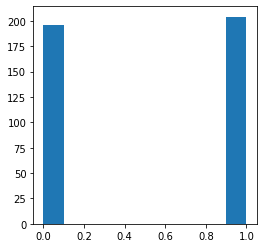

In [31]:
fig, ax = plt.subplots(figsize=(4,4)) 
plt.hist(data['res'])
plt.show()

In [34]:
data['res'].value_counts()


1    204
0    196
Name: res, dtype: int64

In [36]:
total = data.shape[0]
class_1, class_0 = data['res'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 2)*100, round(class_1 / total, 2)*100))

Класс 0 составляет 49.0%, а класс 1 составляет 51.0%.


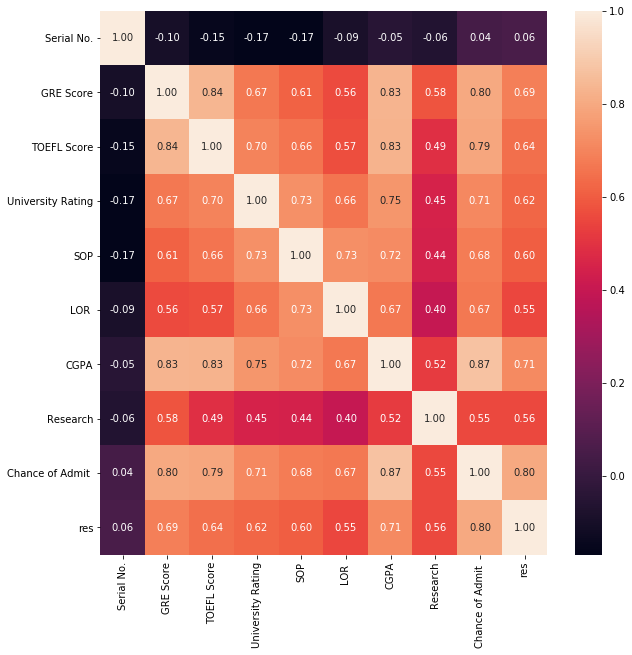

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f')

In [38]:
data.drop(['Serial No.'], axis=1, inplace=True)

In [42]:
class_cols = ['GRE Score', 'TOEFL Score', 'University Rating','CGPA']

In [43]:
X = data[class_cols]
y = data['res']
print(X, "\n")
print(y)

     GRE Score  TOEFL Score  University Rating  CGPA
0          337          118                  4  9.65
1          324          107                  4  8.87
2          316          104                  3  8.00
3          322          110                  3  8.67
4          314          103                  2  8.21
..         ...          ...                ...   ...
395        324          110                  3  9.04
396        325          107                  3  9.11
397        330          116                  4  9.45
398        312          103                  3  8.78
399        333          117                  4  9.66

[400 rows x 4 columns] 

0      1
1      1
2      0
3      1
4      0
      ..
395    1
396    1
397    1
398    0
399    1
Name: res, Length: 400, dtype: int64


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (300, 4)
X_test: (100, 4)
y_train: (300,)
y_test: (100,)


In [47]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [48]:
metricLogger = MetricLogger()

In [49]:
def test_model(model_name, model, metricLogger):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    metricLogger.add('precision', model_name, precision)
    metricLogger.add('recall', model_name, recall)
    metricLogger.add('f1', model_name, f1)
    metricLogger.add('accuracy', model_name, accuracy)
    
    print('*****************************************************')
    print(model)
    print(model_name)
    print("accuracy:", accuracy)
    print("f1_score:", f1)
    print("precision_score:", precision)
    print("recall:", recall)
    print('*****************************************************')

In [54]:
test_model('Random forest', RandomForestClassifier(), metricLogger)
test_model('GB', GradientBoostingClassifier(), metricLogger)

*****************************************************
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Random forest
accuracy: 0.83
f1_score: 0.8316831683168315
precision_score: 0.84
recall: 0.8235294117647058
*****************************************************
*****************************************************
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           ma

In [55]:
metrics = metricLogger.df['metric'].unique()
metrics

array(['precision', 'recall', 'f1', 'accuracy'], dtype=object)

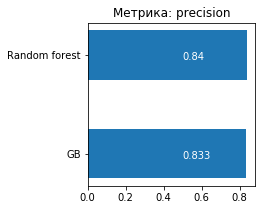

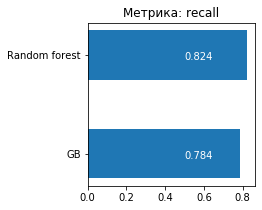

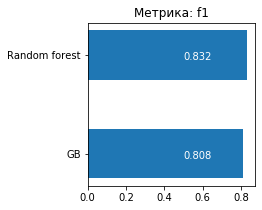

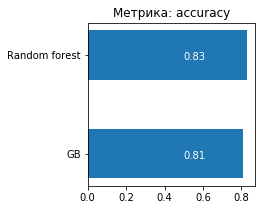

In [56]:
for metric in metrics:
    metricLogger.plot('Метрика: ' + metric, metric, figsize=(3, 3))

В нашем соревновании с небольшим отрывом побеждает модель на основе Случайного леса.Ее метрики превосходят метрики конкурента.